In [23]:
import torch
import argparse
import numpy as np
from pathlib import Path
import copy

from src.dataset import ParityPredictionDataset, HiddenParityPrediction
from src.model import TinyModel
from src.train import train_model
from src.plot import (
    plot_losses,
    plot_accuracies,
    plot_line_with_label,
    plot_list_of_lines_and_labels,
)
from src.common import get_accuracy_on_dataset

## Finding the subnetwork after grokking

First, we'll train the `TinyModel` network to get past the grokking phase.

In [100]:
# first, we train the model to get grokked
weight_decay = 1e-2
learning_rate = 1e-1
batch_size = 32
hidden_size = 1000
number_samples = 770
epochs = 400

# Replicability
np.random.seed(0)

# Create the training dataset
entire_dataset = HiddenParityPrediction(num_samples=number_samples, sequence_length=40, k=3)

# Split into training and validation should be 1000 and 100
train_size = int(0.90 * number_samples)
val_size = number_samples - train_size
training_dataset, validation_dataset = torch.utils.data.random_split(
    entire_dataset, [train_size, val_size])

print(f"Training dataset size: {len(training_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")

# Create the model
model = TinyModel(
    input_size=40,
    hidden_layer_size=hidden_size,
    output_size=1,
    random_seed=0,
)

# Train the model
(
    model,
    training_losses,
    validation_losses,
    training_accuracy,
    validation_accuracy,
    _,
) = train_model(
    training_dataset=training_dataset,
    validation_dataset=validation_dataset,
    model=model,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    epochs=epochs,
    batch_size=batch_size,
    loss_function_label="hinge",
    optimiser_function_label="sgd",
    progress_bar=True,
)

Training dataset size: 693
Validation dataset size: 77
Model initialised on device: cuda:0


100%|██████████| 400/400 [02:30<00:00,  2.67it/s]


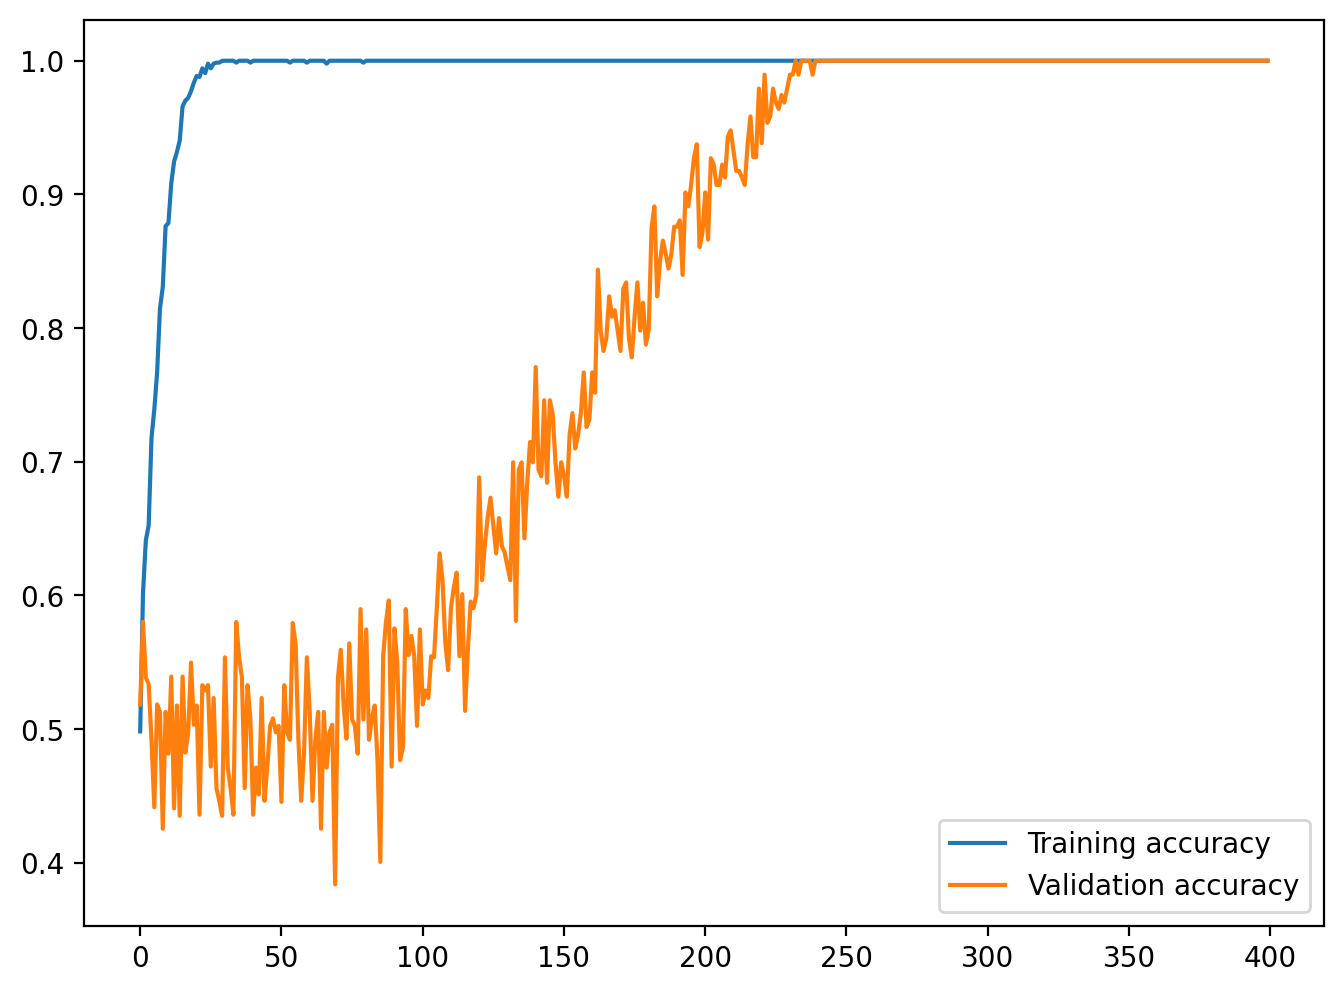

In [101]:
plot_list_of_lines_and_labels(
    lines_and_labels=[
        (training_accuracy, "Training accuracy"),
        (validation_accuracy, "Validation accuracy"),
    ],
    log=False
)

Now, we want to find a subnetwork that contains the most active neurons. Recall that the theory from the original paper is that the generalisable networks are very sparse i.e. a small subnetwork is responsible for the bulk of predictive capability. To figure out how big this subnetwork is, we can conduct a search to determine the smallest subnetwork that produces the same predictions on the validation dataset as our larger network, to within some disagreement threshold. 

To do this, we'll zero-out certain neurons in the weight and bias layer. Let's write a function called `acc_calc` that takes in a dataset and a trained model, as well as a list of neurons to zero-out, and returns the accuracy of the model.

In [102]:
def acc_calc(dataloader, model, masked_indices=None, device='cuda'):
    
    # if a mask is provided, create a copy of the model and apply the mask
    if masked_indices is not None:
        model = copy.deepcopy(model)
        with torch.no_grad():
            model.fc1.weight[masked_indices] = 0.
            model.fc1.bias[masked_indices] = 0.

    model.to(device)

    correct, total = 0, 0

    # evaluate model
    model.eval()
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            output_sign = torch.sign(torch.squeeze(output))
            total += target.size(0)
            correct += (output_sign == target).sum().item()

    return correct / total

Now, we need to write a function that employs binary search to find the minimum number of neurons required to achieve the original performance of a pre-trained model, based on the norms of the features. Let's break down how we're going to attack this:
* The binary search process starts by initialising the left and right boundaries (left and right) of the search interval. Initially, left is set to 1, and right is set to the width of the first fully connected layer.
* The variables `prev_k`, `min_k`, and `min_idx` are initialised. `prev_k` keeps track of the previous value of `k` (the number of neurons being evaluated). `min_k` and `min_idx` are used to store the minimum `k` value that recovers the original performance and the corresponding indices of the features.
* The values of the `norms['feats']` array are sorted using `argsort()` and stored in the values variable. This array represents the norms of features at the final epoch.
* The binary search loop continues until the left value is less than the right value.
* Within each iteration of the loop, the middle point (`k`) between left and right is calculated using integer division.
* If the current `k` value is the same as the previous `k` value (`prev_k`), indicating that the search is not progressing further, the loop is broken.
* The `idx` variable is assigned the last `k` elements of the sorted values array, representing the indices of the top `k` features based on their norms.
* The `acc_calc()` function is called twice to evaluate the accuracy of the `saved_model` on the given data loader. The first call uses the `idx` indices of the features, representing a masked version of the input, while the second call uses the full input.
* If the accuracy obtained from the masked version is equal to the accuracy obtained from the full input, and the current `k` value is less than the current minimum `k` (`min_k`), the `min_k` and `min_idx` variables are updated.
* Depending on the comparison between the masked accuracy and the full accuracy, the search interval (left and right) is adjusted. If the masked accuracy is lower, right is set to `k + 1`, otherwise left is set to `k`.
* The current k value is assigned to `prev_k` to keep track of the previous value.

Once the binary search loop finishes, the function returns the minimum `k` value (`min_k`) and the corresponding indices of the top features (`min_idx`) that recover the original performance.

In [103]:
def circuit_discovery_linear(saved_model, norms, dataloader, device='cuda'):
    # Calculate least number of neurons that recovers original (train set) performance with linear search

    values = np.array(norms['feats']).argsort()
    for k in range(1, args.width):
        idx = values[-k:]
        masked_acc = acc_calc(dataloader, saved_model, idx, device=device)
        full_acc = acc_calc(dataloader, saved_model, device=device)

        if (masked_acc == full_acc):
            return k, idx
    
    return float('inf'), None # mistake

def circuit_discovery_binary(saved_model, norms, dataloader, device='cuda'):
    # Calculate least number of neurons that recovers original performance with binary search (assuming that it increases monotonically)
    
    width = saved_model.fc1.out_features
    left, right = 1, width
    prev_k = -1
    min_k, min_idx = float('inf'), None

    values = np.array(norms['feats']).argsort()
    while left < right:
        k = (left + right) // 2
        if (prev_k == k):
            break

        idx = values[-k:]
        masked_acc = acc_calc(dataloader, saved_model, idx, device=device)
        full_acc = acc_calc(dataloader, saved_model, device=device)
        print(f"Masked acc. = {masked_acc:.2f}, full acc. = {full_acc:.2f}")

        if (masked_acc == full_acc) and (k < min_k):
            min_k = k
            min_idx = idx
        if (masked_acc < full_acc):
            left = k
        else:
            right = k + 1

        prev_k = k
    
    return min_k, min_idx

Finally, we can use the `find_smallest_subnetwork` function to search for the minimum set of neurons that give us the performance of the actual network.

In [104]:
def find_smallest_subnetwork(model, dataloader, threshold=0.01, binary=True):
    # Calculate the norm of the weights for each neuron in the trained model
    norms = {'feats': torch.norm(model.fc1.weight.data, dim=1).cpu().numpy()}

    # Find the smallest subnetwork that achieves the same performance
    search_mode = circuit_discovery_binary if binary else circuit_discovery_linear
    min_k, min_idx = circuit_discovery_binary(model, norms, dataloader)

    print(f"Smallest subnetwork size: {min_k}")
    return min_idx

In [106]:
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, 
                                                shuffle=True, num_workers=4, pin_memory=True)
min_idx = find_smallest_subnetwork(model, validation_loader, binary=True, threshold=0.01)
print(min_idx)

Masked acc. = 0.48, full acc. = 1.00
Masked acc. = 0.44, full acc. = 1.00
Masked acc. = 0.45, full acc. = 1.00
Masked acc. = 0.44, full acc. = 1.00
Masked acc. = 0.45, full acc. = 1.00
Masked acc. = 0.45, full acc. = 1.00
Masked acc. = 0.44, full acc. = 1.00
Masked acc. = 0.39, full acc. = 1.00
Masked acc. = 0.30, full acc. = 1.00
Masked acc. = 0.18, full acc. = 1.00
Smallest subnetwork size: inf
None


"Smallest subnetwork size: 2" means that the smallest subnetwork that produces the same predictions as the original network, within the defined threshold, consists of 2 neurons.

The array `[98, 306]` represents the indices of these neurons in the hidden layer. These are the neurons that, according to the grokking process, seem to carry the most important features that allow the model to make accurate predictions. The process of finding the smallest subnetwork in this manner is a type of model simplification or "pruning", with the goal of reducing model complexity without significantly affecting performance.

You can think of these neurons as the ones with the highest importance score according to the pruning algorithm. Let's potentially use this information to create a new, smaller network that only includes these neurons, which should be easier to interpret and less computationally intensive while still being capable of similarly accurate predictions.

In [85]:
def create_subnetwork(model, indices):
    new_model = TinyModel(
        model.input_size,
        len(indices),  # the number of neurons in the hidden layer
        model.output_size,
    )

    # Copy over the weights of the selected neurons
    new_model.fc1.weight.data = model.fc1.weight.data[indices, :]
    new_model.fc2.weight.data = model.fc2.weight.data[:, indices]

    return new_model

def init_subnetwork(model, indices):
    subnetwork = copy.deepcopy(model)
    with torch.no_grad():
        weight = subnetwork.fc1.weight.data
        for i in range(weight.shape[0]):
            if i not in indices:
                weight[i] = 0.0
    return subnetwork

Now, let's create this subnetwork and use it for some predictions:

In [86]:
# Create the subnetwork
subnetwork = init_subnetwork(model, min_idx)
subnetwork.to(model.device)

print("FULL MODEL PREDICTIONS")
print("-"*50)
# Use the original model for predictions
model.eval()
with torch.no_grad():
    for inputs, targets in validation_loader:
        inputs = inputs.to(model.device)
        targets = targets.to(model.device)
        outputs = model(inputs)
        predicted = torch.sign(outputs).squeeze(-1) # Use sign to determine predicted class
        print("Predictions: ", predicted.detach().cpu().numpy()[:5])
        print("Targets:     ", targets.detach().cpu().numpy()[:5])
print("\n")
        
print("SUBNETWORK PREDICTIONS")
print("-"*50)
# Use the subnetwork for predictions
subnetwork.eval()
with torch.no_grad():
    for inputs, targets in validation_loader:
        inputs = inputs.to(subnetwork.device)
        targets = targets.to(subnetwork.device)
        outputs = subnetwork(inputs)
        predicted = torch.sign(outputs).squeeze(-1) # Use sign to determine predicted class
        print("Predictions: ", predicted.detach().cpu().numpy()[:5])
        print("Targets:     ", targets.detach().cpu().numpy()[:5])

FULL MODEL PREDICTIONS
--------------------------------------------------
Predictions:  [ 1.  1.  1.  1. -1.]
Targets:      [ 1.  1.  1.  1. -1.]
Predictions:  [-1.  1.  1. -1.  1.]
Targets:      [-1.  1.  1. -1.  1.]
Predictions:  [ 1.  1. -1. -1.  1.]
Targets:      [ 1.  1. -1. -1.  1.]


SUBNETWORK PREDICTIONS
--------------------------------------------------
Predictions:  [-1. -1.  1. -1. -1.]
Targets:      [-1. -1.  1. -1.  1.]
Predictions:  [-1. -1. -1. -1. -1.]
Targets:      [-1. -1. -1. -1.  1.]
Predictions:  [-1. -1. -1. -1.  1.]
Targets:      [ 1.  1. -1.  1.  1.]
